# PyVWF: Plotting research results for paper and comparison

In [1]:
# import time
# import xarray as xr
import numpy as np
import pandas as pd

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import matplotlib

from vwf.extras import (
    calc_error,
    overall_error,
    explore_error,
    plot_overall_error
)

bg_colour = '#f0f0f0'
custom_params = {'xtick.bottom': True, 'axes.edgecolor': 'black', 'axes.spines.right': False, 'axes.spines.top': False, 'axes.facecolor': bg_colour, 'mathtext.default': 'regular'}
sns.set_theme(style='darkgrid', rc=custom_params)

In [2]:
cluster_list = [1,5,10,50,100,500,600,700,800,900,1000,2000,3000,3700]
# cluster_list = [1,10,100,500,1000]
time_res_list = ['yearly', 'season', 'bimonth', 'month'] 

country = "DK" 
year_test = 2020 # year you wish to receive a time series for

# country = "DE"
# year_test = 2019 # year you wish to receive a time series for

# SETTING THE RUN
args = None,None,None # 1) % to remove from data,
# 2) monthly limit to interpretating NaN, 
# 3) turbine to fix to #'GE.1.5se' # 'Vestas.V66.2000'
run = 'run/'+country
if (args[0] == None) & (args[1] == None) & (args[2] == None):
    run += '-standard'
else:
    if args[0] != None:
        run += '-r'+str(args[0])
    if args[1] != None:
        run += '-i'+str(args[1])
    if args[2] != None:
        run += '-'+args[2]

print(run)
# run = 'data-archive/data0028'
# run = 'data'

run/DK-standard


In [3]:
# import vwf.VWF_Model as model
# vwf_model = model.VWF(country, cluster_list, time_res_list, args[0], args[1], args[2])
# vwf_model.test(year_test,None)

# Analysing Input Data

In [3]:
def regional_cf(regions, num_clu, time_res, turb_info, test=False):
    # create the regional index
    df = pd.DataFrame(list(zip(turb_info.lat, turb_info.lon)),
               columns =['lat', 'lon'])
    kmeans = KMeans(init="random",n_clusters=regions,n_init=10,max_iter=300,random_state=42)
    kmeans.fit(df)
    
    # adding cluster labels to data
    turb_info['region_delete'] = kmeans.labels_
    
    # order the clusters/labels from left to right
    region_info = turb_info.groupby('region_delete', as_index=False)[['lat','lon']].mean()
    region_info = region_info.sort_values('lon').reset_index(drop=True)
    region_info['region'] = region_info.index
    turb_info = turb_info.merge(region_info[['region_delete','region']], on='region_delete',how='left')
    turb_info = turb_info.drop('region_delete',axis=1)
    
    ## Use this to filter out offshore etc for plotting
    # turb_info = turb_info.drop(turb_info[(turb_info['type'] == 'offshore') & (turb_info['In training?'] == 'No')].index).reset_index(drop=True)
    # turb_info = turb_info.drop(turb_info[(turb_info['In training?'] == 'No')].index).reset_index(drop=True)

    region_info = turb_info.copy()

    def weighted_region_cf(df, turb_info, name):
        df = df.melt(
                id_vars=["time"], # adding in turbine ID for merging
                var_name="ID", 
                value_name=name
            )
        
        df["ID"] = df["ID"].astype(str)
        turb_info["ID"] = turb_info["ID"].astype(str)

        ## Use this to filter out offshore etc for plotting
        df = df.loc[df['ID'].isin(turb_info['ID'])].reset_index(drop=True)
        
        df_all = df.copy()
        df = df.merge(turb_info[['ID','region','capacity','lat','lon']],on='ID')
    
        def weighted_avg(df, values, weights):
                return (df[values] * df[weights]).sum() / df[weights].sum()
    
        wavg = lambda x: weighted_avg(df.loc[x.index], name, 'capacity')

        df_region = df.groupby('region').agg({name: wavg, 'lat': np.mean, 'lon': np.mean})
        return df_region, df_all
    
    # loading files
    obs = pd.read_csv(run+'/results/capacity-factor/'+country+"_"+str(year_test)+'_obs_cf.csv', parse_dates=['time'])
    unc = pd.read_csv(run+'/results/capacity-factor/'+country+"_"+str(year_test)+'_unc_cf.csv', parse_dates=['time'])
    obs_weighted, obs_all = weighted_region_cf(obs, turb_info, 'obs')
    unc_weighted, unc_all = weighted_region_cf(unc, turb_info, 'unc')

    if test == True:
        def load_cf(num_clu, time_res, year_test=2020):
            cor = pd.read_csv(run+'/results/capacity-factor/'+country+"_"+str(year_test)+'_'+time_res+'_'+str(num_clu)+'_cor_cf.csv', parse_dates=['time'])
            return cor
            
        cor = load_cf(num_clu, time_res)
        cor_one = load_cf(1, 'yearly')
        cor_weighted, cor_all = weighted_region_cf(cor, turb_info, 'cor')
        cor_one_weighted, cor_one_all = weighted_region_cf(cor_one, turb_info, 'cor-base')

        all_cf = obs_all.merge(unc_all,on=['ID', 'time']).merge(cor_all,on=['ID', 'time']).merge(cor_one_all,on=['ID', 'time'])
        all_cf = all_cf.merge(turb_info[['ID','lat','lon','capacity']],on='ID')
        weighted_region = obs_weighted.merge(unc_weighted[['unc']],on=['region']).merge(cor_weighted[['cor']],on=['region']).merge(cor_one_weighted[['cor-base']],on=['region'])

    else: 
        all_cf = obs_all.merge(unc_all,on=['ID', 'time'])
        all_cf = all_cf.merge(turb_info[['ID','lat','lon','capacity']],on='ID')
        weighted_region = obs_weighted.merge(unc_weighted[['unc']],on=['region'])
    
    # # return weighted_region, all_cf, region_info
    region_cf = weighted_region.reset_index().melt(id_vars=['region','lat','lon'],var_name="model",value_name="cf")

    region_cf['cf'] = region_cf['cf']*100
    
    return region_cf, all_cf, region_info

def plot_regional_error(run, df_metrics, name):
    fig, axes = plt.subplots(1, 2, figsize=(12, 3))
    
    sns.lineplot(
        x='region',y='rmse',
        data = df_metrics[((df_metrics['time_res'] == 'season') | (df_metrics['time_res'] == 'yearly')) & ((df_metrics['num_clu'] == 1) | (df_metrics['num_clu'] == 500) | (df_metrics['num_clu'] == 3000))],
        hue ="num_clu",style="time_res",palette="tab10",
        ax = axes[0],
        legend = False
    )
    axes[0].set_ylabel('RMSE')
    axes[0].set_xlabel('Region')
    
    sns.lineplot(
        x='region',y='mae',
        data = df_metrics[((df_metrics['time_res'] == 'season') | (df_metrics['time_res'] == 'yearly')) & ((df_metrics['num_clu'] == 1) | (df_metrics['num_clu'] == 500) | (df_metrics['num_clu'] == 3000))],
        hue ="num_clu",style="time_res",palette="tab10",
        ax = axes[1],
        legend = True
    )
    
    axes[1].set_ylabel('MAE')
    axes[1].set_xlabel('Region')
    
    # fixing the legend labels and sharing it over whole plot.
    axes[1].get_legend().remove()
    handles, labels = plt.gca().get_legend_handles_labels()
    # print(labels)
    labels = ['$n_{clu}$', '1', '500','3000', '$t_{freq}$', 'Fixed', 'Seasonal']
    plt.legend(handles, labels, ncol=1, loc='right', bbox_to_anchor=(1.3, 0.5))
    plt.tight_layout()
    # plt.savefig(run+'/plots/'+country+'_'+name+'_error.png', bbox_inches='tight')
    return plt.tight_layout()

def plot_monthly_error(metric, run, country, df_metrics):
    # metric = 'rmse' # choose between 'mae', 'rmse'
    base_clu = 1
    choice_clu = 500
    fig, axes = plt.subplots(1, 2, figsize=(12, 3),sharey='all')
    sns.lineplot(
        x="month",y=metric,
        data = df_metrics[(df_metrics['num_clu'] == base_clu)],
        hue ="time_res",style= "time_res",
        hue_order = ['month', 'bimonth', 'season', 'yearly'],
        style_order= ['month', 'bimonth', 'season', 'yearly'],
        ax = axes[0],legend = False
    )
    sns.lineplot(
        x="month",y=metric,
        data = df_metrics[(df_metrics['num_clu'] == choice_clu) & (df_metrics['time_res'] != 'uncorrected')],
        hue ="time_res",style= "time_res",
        hue_order = ['month', 'bimonth', 'season', 'yearly'],
        style_order= ['month', 'bimonth', 'season', 'yearly'],
        ax = axes[1],legend = True
    )
    
    axes[0].set_ylabel('N'+metric.upper() )
    axes[0].set_xlabel('Month')
    axes[0].set_xticks(range(1,13))
    axes[0].set_title('$n_{clu}$ = '+str(base_clu))
    axes[1].set_ylabel(metric)
    axes[1].set_xlabel('Month')
    axes[1].set_xticks(range(1,13))
    axes[1].set_title('$n_{clu}$ = '+str(choice_clu))
    
    # fixing the legend labels and sharing it over whole plot.
    axes[1].get_legend().remove()
    handles, labels = plt.gca().get_legend_handles_labels()
    labels = ['Monthly', 'Bimonthly',  'Seasonal', 'Fixed'] # renaming labels
    plt.legend(handles, labels, ncol=1, loc='right', bbox_to_anchor=(1.3, 0.5), title='$t_{freq}$')
    plt.tight_layout()
    plt.savefig(run+'/plots/'+country+'_monthly_'+metric+'.png', bbox_inches='tight')
    return plt.tight_layout()

In [4]:
turb_info_train = pd.read_csv(run+'/training/simulated-turbines/'+country+'_train_turb_info.csv')
# train_obs = pd.read_csv(run+'/results/capacity-factor/'+country+'_train_obs_cf.csv')

turb_info = pd.read_csv(run+'/training/simulated-turbines/'+country+"_"+str(year_test)+'_turb_info.csv')
test_obs = pd.read_csv(run+'/results/capacity-factor/'+country+"_"+str(year_test)+'_obs_cf.csv', parse_dates=['time'])

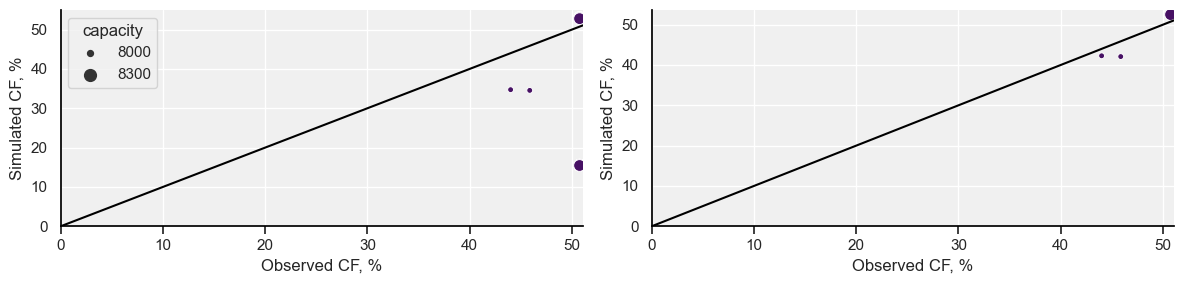

### Training analysis

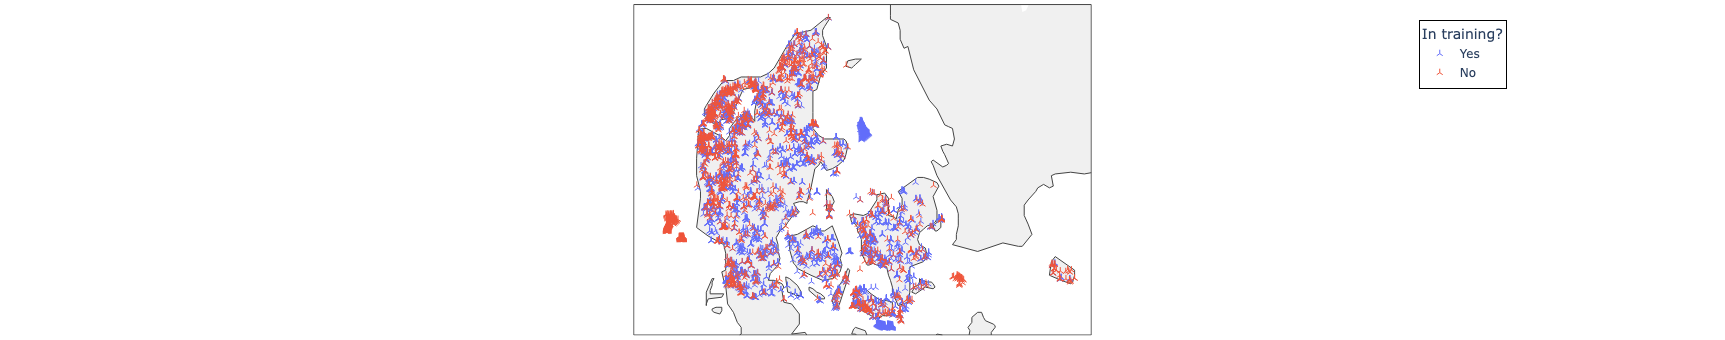

In [25]:
# Plot of where all the turbines used in training are located
turb_info['In training?'] = np.where(turb_info.ID.isin(turb_info_train.ID), 'Yes', 'No')
fig = px.scatter_geo(turb_info,lat='lat',lon='lon',color = 'In training?')

fig.update_geos(
    resolution=50, 
    center=dict(lon=11.2, lat=56.2),
    lataxis_range=[54.6, 58], 
    lonaxis_range=[7,15.5],
    projection_type='mercator',
    landcolor=bg_colour
)
fig.update_traces(marker=dict(size=5, symbol="y-up-open"))
fig.update_layout(
    margin=dict(l=5, r=5, t=5, b=5),width = 465, height = 340,
    legend=dict(orientation="v", yanchor="middle", y=0.85, xanchor="center", x=0.85, bordercolor="Black",borderwidth=1)
)
# fig.update_layout(
#     margin=dict(l=5, r=5, t=5, b=5),width = 465, height = 340,
#     legend=dict(orientation="v", yanchor="middle", y=0.71, xanchor="center", x=0.93, title="Region", 
#     bordercolor="Black",borderwidth=1
#     )
# )
fig.show()

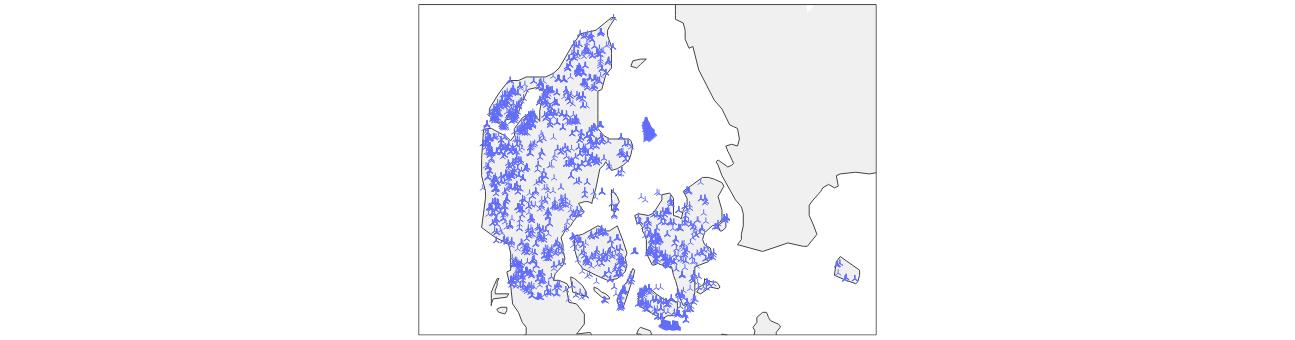

In [26]:
# Plot of where all the turbines used in training are located
# turb_info['In training?'] = np.where(turb_info.ID.isin(turb_info_train.ID), 'Yes', 'No')
fig = px.scatter_geo(turb_info_train,lat='lat',lon='lon')

fig.update_geos(
    resolution=50, 
    center=dict(lon=11.2, lat=56.2),
    lataxis_range=[54.6, 58], 
    lonaxis_range=[7,15.5],
    projection_type='mercator',
    landcolor=bg_colour
)
fig.update_traces(marker=dict(size=5, symbol="y-up-open"))
fig.update_layout(
    margin=dict(l=5, r=5, t=5, b=5),width = 465, height = 340,
)
# fig.update_layout(
#     margin=dict(l=5, r=5, t=5, b=5),width = 465, height = 340,
#     legend=dict(orientation="v", yanchor="middle", y=0.71, xanchor="center", x=0.93, title="Region", 
#     bordercolor="Black",borderwidth=1
#     )
# )
fig.show()

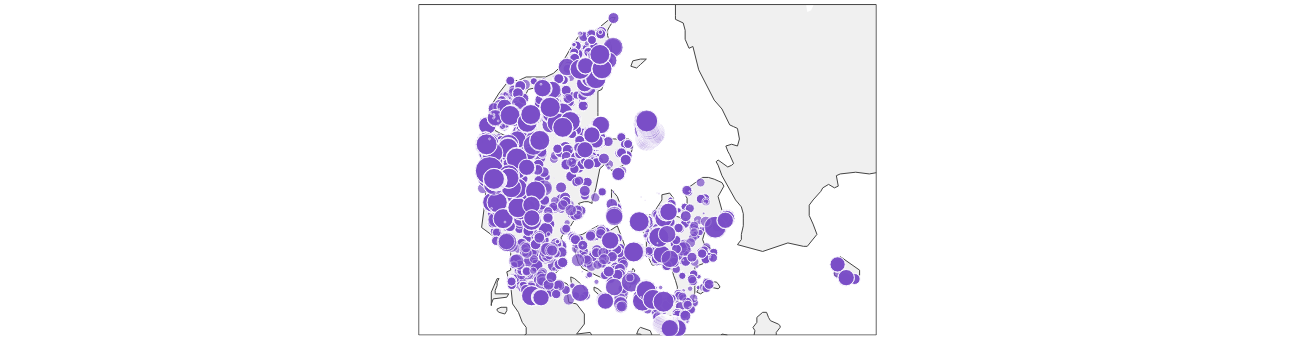

In [22]:
# Plot of where all the turbines used in training are located with their capacity shown by size
fig = px.scatter_geo(turb_info_train,lat='lat',lon='lon',size="capacity")

fig.update_geos(
    resolution=50, 
    center=dict(lon=11.2, lat=56.2),
    lataxis_range=[54.6, 58], 
    lonaxis_range=[7,15.5],
    projection_type='mercator',
    landcolor=bg_colour
)
fig.update_traces(marker=dict(color='#7a4ec7'))
fig.update_layout(margin=dict(l=5, r=5, t=5, b=5),width = 465, height = 340)
fig.show()

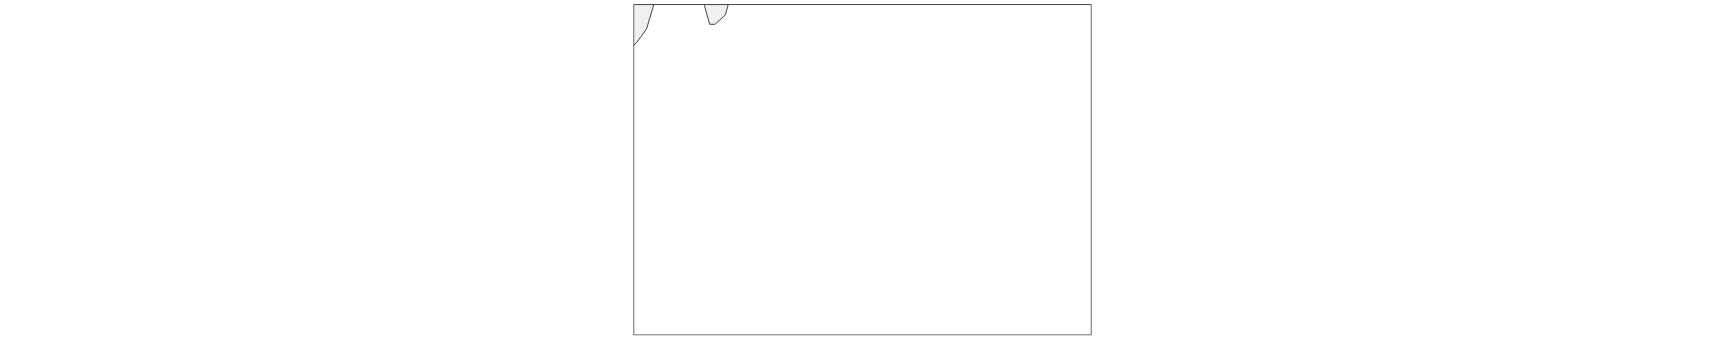

In [58]:
ignore, ignore, clustering_df = regional_cf(400, 1, 'yearly', turb_info_train)

clustering_df["region"] = clustering_df["region"].astype(str)

fig = px.scatter_geo(clustering_df, lat ='lat',lon ='lon', color = 'region', color_discrete_sequence=px.colors.qualitative.Plotly)
fig.update_geos(
    resolution=50, 
    center=dict(lon=11.2, lat=56.2),
    lataxis_range=[54.6, 58], 
    lonaxis_range=[7,15.5],
    projection_type='mercator',
    landcolor=bg_colour
)
fig.update_traces(marker=dict(size=4, symbol="y-up-open"))

fig.update(layout_coloraxis_showscale=False, layout_showlegend=False)
fig.update_layout(margin=dict(l=5, r=5, t=5, b=5),width = 465, height = 340)
fig.show()

### ERA 5 Bias Analysis

In [ ]:
gen_train = pd.read_csv(run+'/training/'+country+'_train_gen_cf.csv')

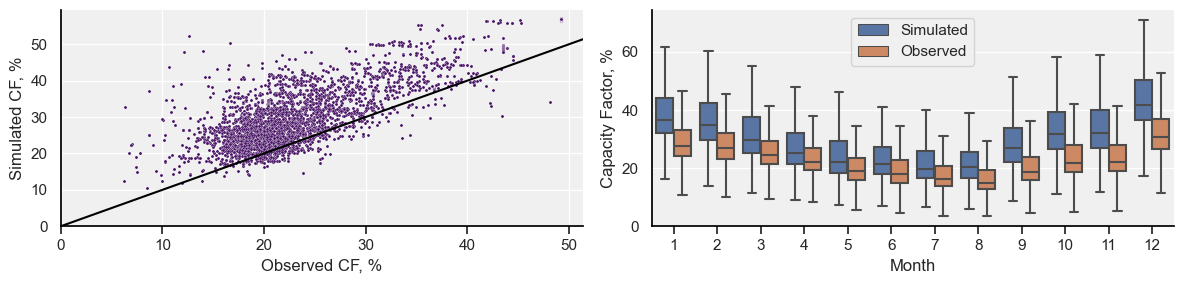

In [39]:
comp_month = gen_train.groupby(['ID','month']).agg({"sim": np.mean, "obs": np.mean}).reset_index()
comp_month = comp_month.melt(id_vars=['ID','month'], var_name="model", value_name="cf")
comp_total = gen_train.groupby(['ID']).agg({"sim": np.mean, "obs": np.mean}).reset_index()
comp_total['obs'] = comp_total['obs']*100
comp_total['sim'] = comp_total['sim']*100
comp_month['cf'] = comp_month['cf']*100

fig, axes = plt.subplots(1, 2, figsize=(12, 3))

sns.scatterplot(x="obs",y="sim",data=comp_total,s=5,color='#471164FF',ax=axes[0])
axes[0].set_ylabel('Simulated CF, %')
axes[0].set_xlabel('Observed CF, %')
axes[0].set_xlim(0)
axes[0].set_ylim(0)
x0, x1 = axes[0].get_xlim()
y0, y1 = axes[0].get_ylim()
lims = [max(x0, y0), min(x1, y1)]
axes[0].plot(lims, lims, 'black')

sns.boxplot(data=comp_month,x="month", y="cf", hue="model",showfliers = False, ax=axes[1])
axes[1].set_ylabel('Capacity Factor, %')
axes[1].set_xlabel('Month')
axes[1].get_legend().remove()
# axes[1].set_xlim(0)
axes[1].set_ylim(0)

handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles, ['Simulated', 'Observed'], ncol=1, loc='upper center')
plt.tight_layout()
plt.savefig(run+'/plots/era5_'+country+'_anaylsis.png', bbox_inches='tight')

In [46]:
base_clu = 1
base_freq = 'yearly'
mapped_cf, ignore, ignore = regional_cf(3706, base_clu, base_freq, turb_info_train)

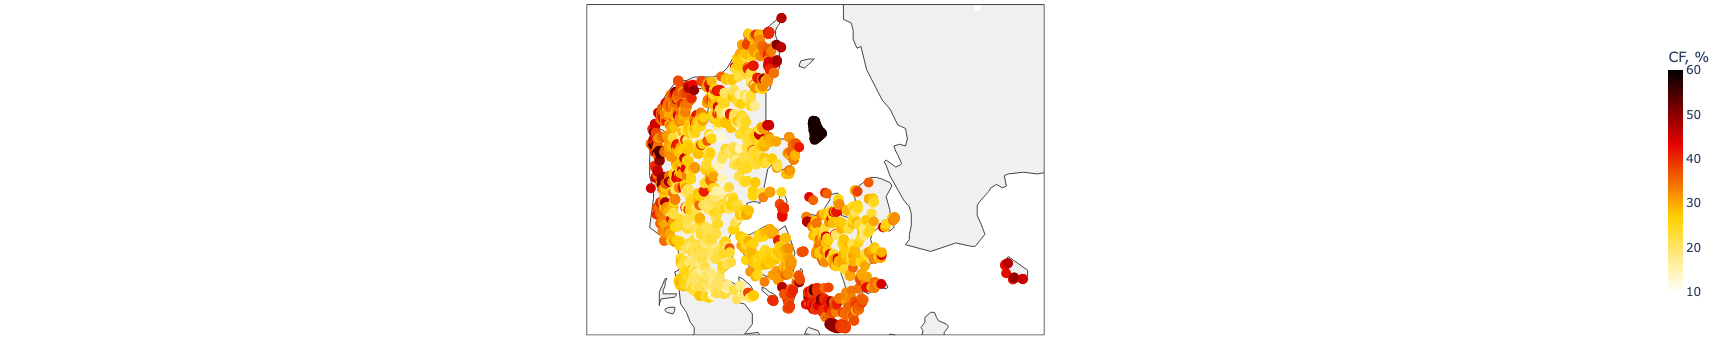

In [62]:
param = 'unc' # choose between 'unc', 'cor', obs'

fig = px.scatter_geo(
    mapped_cf[mapped_cf['model']==param],
    lat='lat',
    lon='lon', 
    color = 'cf',
    color_continuous_scale='hot_r', 
    range_color=(10,60)
) 
fig.update_geos(
    resolution=50, 
    center=dict(lon=11.2, lat=56.2),
    lataxis_range=[54.6, 58], 
    lonaxis_range=[7,15.5],
    projection_type='mercator',
    landcolor=bg_colour
)
fig.update_traces(marker=dict(size=10, opacity=1))
fig.update_layout(
    margin=dict(l=5, r=5, t=5, b=5),
    width = 465, height = 340,
    coloraxis_colorbar=dict(len=0.8,thickness=15)
)
fig.layout.coloraxis.colorbar.title = 'CF, %'
fig.show()

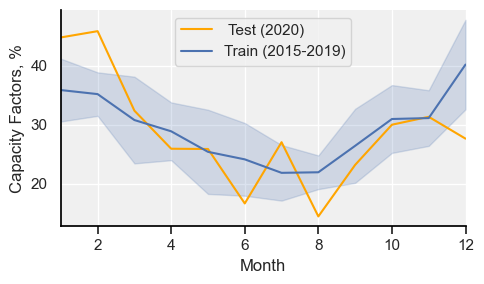

In [154]:
def wavg_cf_monthly(df, turb_info):
    """
    Calculates the weighted monthly capacity factor by capacity.
    
    Args:
        df (pandas.DataFrame): time-series of capacity factors for turbines/farms
        turb_info (pandas.DataFrame): turbine metadata including height and coordinates
        
    Returns:
        series: weighted average of capacity factor for dataframe
    """
    df = df.groupby(pd.Grouper(key='time',freq='M')).mean()
    df = df.reset_index()
    df = df.melt(
            id_vars=["time"], # adding in turbine ID for merging
            var_name="ID", 
            value_name="cf"
        )
    
    df["ID"] = df["ID"].astype(str)
    turb_info["ID"] = turb_info["ID"].astype(str)
    df = pd.merge(df, turb_info[['ID','capacity']], on=['ID'], how='left')

    def weighted_avg(df, values, weights):
            return (df[values] * df[weights]).sum() / df[weights].sum()

    wavg = lambda x: weighted_avg(df.loc[x.index], 'cf', 'capacity')
    
    df = df.groupby(pd.Grouper(key='time',freq='M')).agg({"cf": wavg})
    return df.reset_index()

def wavg_cf_monthly_train(df, turb_info):  
    df["ID"] = df["ID"].astype(str)
    turb_info["ID"] = turb_info["ID"].astype(str)
    df = pd.merge(df, turb_info[['ID','capacity']], on=['ID'], how='left')

    def weighted_avg(df, values, weights):
            return (df[values] * df[weights]).sum() / df[weights].sum()

    wavg = lambda x: weighted_avg(df.loc[x.index], 'cf', 'capacity')
    
    df = df.groupby(['year','month']).agg({"cf": wavg})
    
    return df.reset_index()

obs_cf_test = wavg_cf_monthly(test_obs, turb_info)
obs_cf_test['year'] = pd.DatetimeIndex(obs_cf_test['time']).year
obs_cf_test['month'] = pd.DatetimeIndex(obs_cf_test['time']).month
obs_cf_test = obs_cf_test.drop('time',axis=1)[['year','month','cf']]
obs_cf_test['cf'] = obs_cf_test['cf'] * 100

train_obs.columns = ['ID','year','month','cf']
obs_cf_train = wavg_cf_monthly_train(train_obs, turb_info_train)
obs_cf_train['cf'] = obs_cf_train['cf'] * 100


plt.figure(figsize=(5,3))
sns.lineplot(
    x= "month", y= "cf", data = obs_cf_test,
    legend = True, color = 'orange', label =' Test (2020)'
)
sns.lineplot(
    x= "month", y= "cf", data = obs_cf_train, estimator = 'mean', errorbar='sd',
    color='b', label='Train (2015-2019)', legend = True)
handles, labels = plt.gca().get_legend_handles_labels()
plt.ylabel('Capacity Factors, %')
plt.xlabel('Month')
plt.xlim(1, 12)
plt.legend(handles, labels, ncol=1, loc='upper center')
plt.tight_layout()
plt.savefig(run+'/plots/'+country+'_obs_cf.png', bbox_inches='tight')

### Error Plots

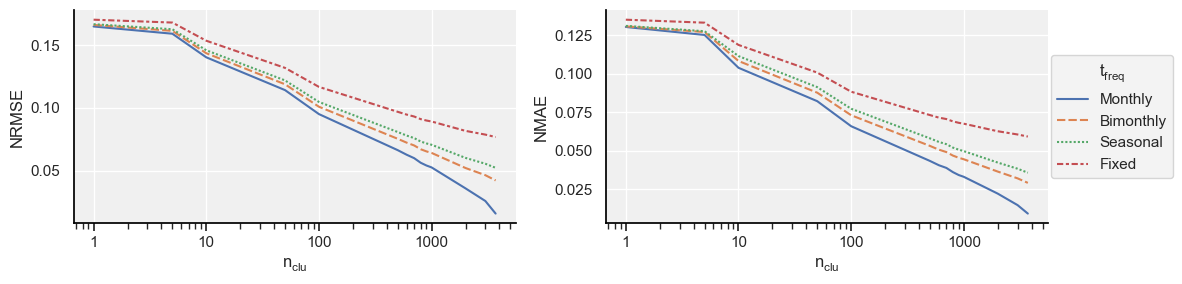

In [6]:
train_metrics = overall_error(run, country, turb_info_train, cluster_list, time_res_list, True)
plot_overall_error(run, country, train_metrics, 'train')

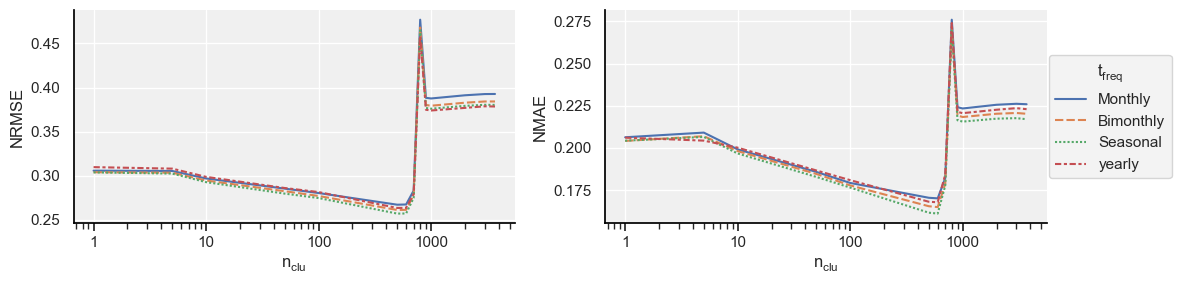

In [5]:
test_metrics = overall_error(run, country, turb_info, cluster_list, time_res_list, False, year_test)
plot_overall_error(run, country, test_metrics, 'test')

In [7]:
test_metrics.sort_values('mae')

num_clu     time_res      rmse       mae
26      600       season  0.257278  0.161077
22      500       season  0.257179  0.161602
27      600      bimonth  0.261435  0.164909
23      500      bimonth  0.261260  0.165440
25      600       yearly  0.263629  0.167785
21      500       yearly  0.263574  0.168091
28      600        month  0.267495  0.170110
24      500        month  0.267241  0.170453
18      100       season  0.274802  0.176494
30      700       season  0.274954  0.177664
19      100      bimonth  0.277145  0.177796
31      700      bimonth  0.278217  0.178717
20      100        month  0.280461  0.179252
17      100       yearly  0.281574  0.180916
32      700        month  0.283238  0.182086
14       50       season  0.279800  0.182819
29      700       yearly  0.279400  0.184209
15       50      bimonth  0.282538  0.184593
16       50        month  0.285487  0.185796
13       50       yearly  0.286152  0.186660
10       10       season  0.292808  0.196726
11       10      bimonth  0.294661  0.198135
12       10        month  0.296963  0.199150
9        10       yearly  0.298816  0.200173
3         1      bimonth  0.304044  0.204176
2         1       season  0.303889  0.204304
5         5       yearly  0.308130  0.204343
1         1       yearly  0.309828  0.206103
4         1        month  0.305834  0.206334
6         5       season  0.302510  0.206535
7         5      bimonth  0.303499  0.206949
8         5        month  0.305476  0.209102
42     1000       season  0.376056  0.215628
38      900       season  0.376892  0.216414
54     3700       season  0.380390  0.217048
46     2000       season  0.379308  0.217364
50     3000       season  0.380475  0.217666
43     1000      bimonth  0.379436  0.218356
39      900      bimonth  0.380282  0.219241
55     3700      bimonth  0.384268  0.220270
47     2000      bimonth  0.382860  0.220289
41     1000       yearly  0.374023  0.220634
51     3000      bimonth  0.384243  0.220735
37      900       yearly  0.374880  0.221393
45     2000       yearly  0.376991  0.222665
53     3700       yearly  0.378558  0.222999
44     1000        month  0.387660  0.223410
49     3000       yearly  0.378782  0.223593
40      900        month  0.388376  0.224167
48     2000        month  0.391275  0.225611
56     3700        month  0.392756  0.225928
52     3000        month  0.392661  0.226192
34      800       season  0.464845  0.270152
35      800      bimonth  0.468042  0.271590
33      800       yearly  0.458185  0.274128
36      800        month  0.476959  0.276066
0         1  uncorrected  0.464135  0.354009

In [7]:
temporal_metrics = explore_error('month', run,  year_test, country, turb_info, cluster_list, time_res_list)

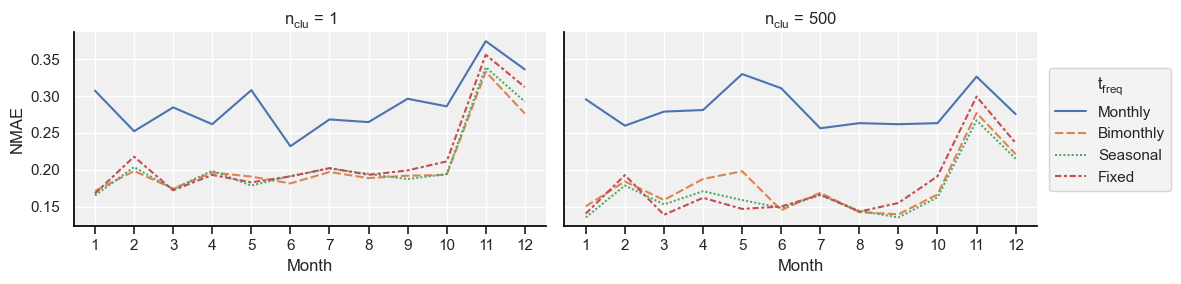

In [10]:
metric = 'mae' # choose between 'mae', 'rmse'
plot_monthly_error(metric, run, country, temporal_metrics)

### Exploring Spatial Resolution

In [11]:
def regional_info(regions,turb_info):
    # create the regional index
    df = pd.DataFrame(list(zip(turb_info.lat, turb_info.lon)),
               columns =['lat', 'lon'])
    kmeans = KMeans(init="random",n_clusters=regions,n_init=10,max_iter=300,random_state=42)
    kmeans.fit(df)
    
    # adding cluster labels to data
    turb_info['region_delete'] = kmeans.labels_
    
    # order the clusters/labels from left to right
    region_info = turb_info.groupby('region_delete', as_index=False)[['lat','lon']].mean()
    region_info = region_info.sort_values('lon').reset_index(drop=True)
    region_info['region'] = region_info.index
    turb_info = turb_info.merge(region_info[['region_delete','region']], on='region_delete',how='left')
    turb_info = turb_info.drop('region_delete',axis=1)
    
    ## Use this to filter out offshore etc for plotting
    # turb_info = turb_info.drop(turb_info[(turb_info['type'] == 'offshore') & (turb_info['In training?'] == 'No')].index).reset_index(drop=True)
    # turb_info = turb_info.drop(turb_info[(turb_info['type'] == 'offshore')].index).reset_index(drop=True)
    # turb_info = turb_info.drop(turb_info[(turb_info['In training?'] == 'No')].index).reset_index(drop=True)
    
    return turb_info

def plot_regional_error(metric, run, df_metrics, name):
    choice1 = 1
    choice2 = 600
    choice3 = 3700
    fig, axes = plt.subplots(1, figsize=(6, 3))
    
    sns.lineplot(
        x='region',y=metric,
        data = df_metrics[((df_metrics['time_res'] == 'season') | (df_metrics['time_res'] == 'yearly')) & ((df_metrics['num_clu'] == choice1) | (df_metrics['num_clu'] == choice2) | (df_metrics['num_clu'] == choice3))],
        hue ="num_clu",style="time_res",palette="tab10",
        ax = axes,
        legend = True
    )
    axes.set_ylabel('N'+ metric.upper() )
    axes.set_xlabel('Region')
    axes.set_ylim(0.05,0.47)
    # axes.set_xlim(0,7)
    axes.set_xticks([0,1,2,3,4,5,6,7])

    # fixing the legend labels and sharing it over whole plot.
    axes.get_legend().remove()
    handles, labels = plt.gca().get_legend_handles_labels()
    # print(labels)
    labels = ['$n_{clu}$', str(choice1), str(choice2),str(choice3), '$t_{freq}$', 'Fixed', 'Seasonal']
    plt.legend(handles, labels, ncol=1, loc='right', bbox_to_anchor=(1.5, 0.5))
    plt.tight_layout()
    plt.savefig(run+'/plots/'+country+'_regional_'+name+'_N'+metric.upper()+'.png', bbox_inches='tight')
    return plt.tight_layout()

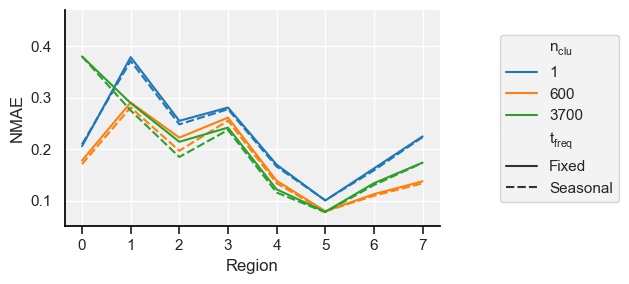

In [12]:
regions = 8
region_info = regional_info(regions, turb_info)
spatial_metrics = explore_error('region', run,  year_test, country, region_info, [1,600,3700], time_res_list)
metric = 'mae'
# plot_regional_error(metric, run, spatial_metrics, 'no_offshore')
# plot_regional_error(metric, run, spatial_metrics, 'no_new_offshore')
# plot_regional_error(metric, run, spatial_metrics, 'no_new_all')
plot_regional_error(metric, run, spatial_metrics, 'all')

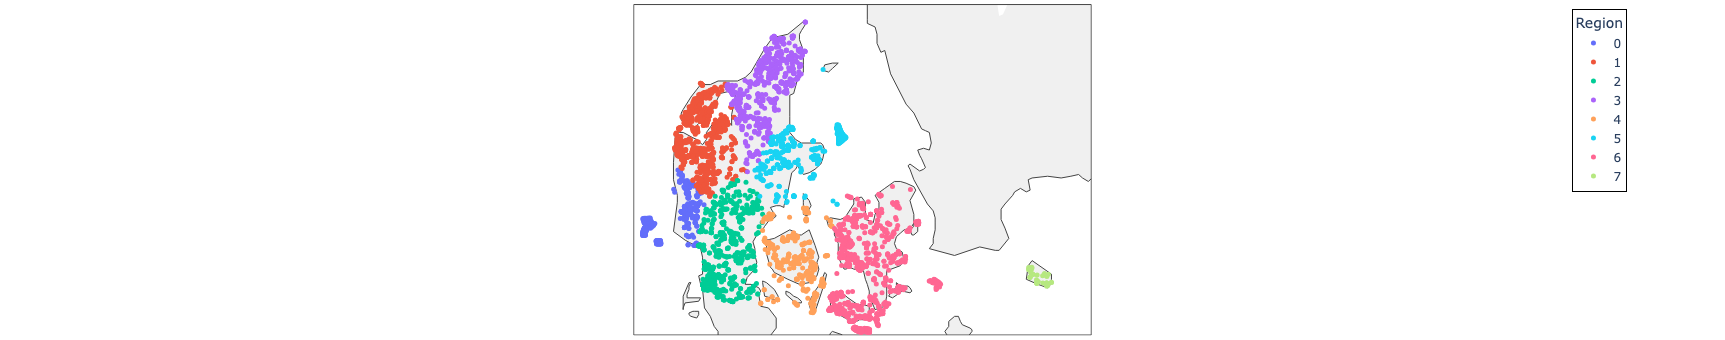

In [281]:
region_info["region"] = region_info["region"].astype(str)
fig = px.scatter_geo(region_info, lat ='lat',lon ='lon', color = 'region', category_orders={"region": ["0","1", "2", "3", "4", "5","6","7"]})

fig.update_geos(
    resolution=50, 
    center=dict(lon=11.2, lat=56.2),
    lataxis_range=[54.6, 58], 
    lonaxis_range=[7,15.5],
    projection_type='mercator',
    landcolor=bg_colour
)
fig.update_traces(marker=dict(size=5))

# fig.add_scattergeo(
#     lat = region_info.groupby('region')[['lat','lon']].mean()['lat'],
#     lon = region_info.groupby('region')[['lat','lon']].mean()['lon'],
#     text = region_info.groupby('region')[['lat','lon']].mean().index,
#     mode = 'text + markers',
#     textposition = "middle center",
#     textfont = dict(family = 'Droid Sans Mono',size = 15,color = "white"),
#     marker = dict(size=18,symbol="square",color="black",opacity=0.5)
#     )
# fig.update(layout_coloraxis_showscale=False, layout_showlegend=False)
fig.update_layout(
    margin=dict(l=5, r=5, t=5, b=5),width = 465, height = 340,
    legend=dict(orientation="v", yanchor="middle", y=0.71, xanchor="center", x=0.93, title="Region", 
    bordercolor="Black",borderwidth=1
    )
)
fig.show()

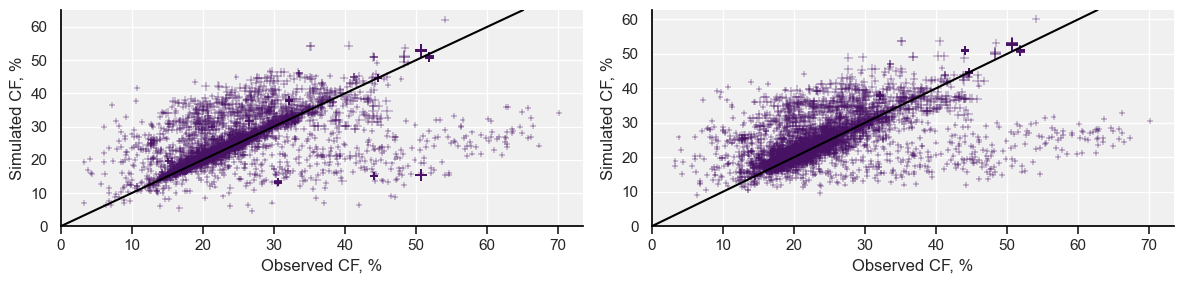

In [58]:
test_obs = pd.read_csv(run+'/results/capacity-factor/'+country+"_"+str(year_test)+'_obs_cf.csv', parse_dates=['time'])
test_obs['time'] = pd.to_datetime(test_obs['time'])
test_obs['month'] = test_obs.time.dt.month
test_obs_monthly = test_obs.drop(columns=['time']).set_index('month').reset_index()
test_obs_monthly = test_obs_monthly.melt(id_vars=['month'], var_name='ID', value_name='cf')
test_obs_total = test_obs_monthly.groupby('ID')['cf'].mean().reset_index()

df_sim = pd.read_csv(run+'/results/capacity-factor/'+country+"_"+str(year_test)+'_'+'yearly'+'_'+str(3700)+'_cor_cf.csv', parse_dates=['time'])
df_sim['time'] = pd.to_datetime(df_sim['time'])
df_sim['month'] = df_sim.time.dt.month
df_sim_monthly = df_sim.drop(columns=['time']).groupby('month').mean().reset_index()
df_sim_monthly = df_sim_monthly.melt(id_vars=['month'], var_name='ID', value_name='cf')
test_cor_total = df_sim_monthly.groupby('ID')['cf'].mean().reset_index()

df_sim = pd.read_csv(run+'/results/capacity-factor/'+country+"_"+str(year_test)+'_'+'yearly'+'_'+str(500)+'_cor_cf.csv', parse_dates=['time'])
df_sim['time'] = pd.to_datetime(df_sim['time'])
df_sim['month'] = df_sim.time.dt.month
df_sim_monthly = df_sim.drop(columns=['time']).groupby('month').mean().reset_index()
df_sim_monthly = df_sim_monthly.melt(id_vars=['month'], var_name='ID', value_name='cf_sim2')
test2_cor_total = df_sim_monthly.groupby('ID')['cf_sim2'].mean().reset_index()

merged = pd.merge(test_cor_total, test_obs_total, on=['ID'], suffixes=('_sim', '_obs'))
merged = merged.merge(test2_cor_total, on=['ID'])
merged['cf_obs'] = merged['cf_obs']*100
merged['cf_sim'] = merged['cf_sim']*100
merged['cf_sim2'] = merged['cf_sim2']*100

turb_info['ID'] = turb_info['ID'].apply(str)
merged = pd.merge(merged, turb_info[['ID', 'capacity']], on='ID')
# merged = merged[merged['capacity'] >= 8000]
merged

fig, axes = plt.subplots(1, 2, figsize=(12, 3))

sns.scatterplot(x='cf_obs',y='cf_sim',size='capacity',data=merged,marker="+",color='#471164FF',ax=axes[0],legend=False)
axes[0].set_ylabel('Simulated CF, %')
axes[0].set_xlabel('Observed CF, %')
axes[0].set_xlim(0)
axes[0].set_ylim(0)
x0, x1 = axes[0].get_xlim()
y0, y1 = axes[0].get_ylim()
lims = [max(x0, y0), min(x1, y1)]
axes[0].plot(lims, lims, 'black')

sns.scatterplot(x='cf_obs',y='cf_sim2',size='capacity',data=merged,marker="+",color='#471164FF',ax=axes[1],legend=False)
axes[1].set_ylabel('Simulated CF, %')
axes[1].set_xlabel('Observed CF, %')
axes[1].set_xlim(0)
axes[1].set_ylim(0)
x0, x1 = axes[1].get_xlim()
y0, y1 = axes[1].get_ylim()
lims = [max(x0, y0), min(x1, y1)]
axes[1].plot(lims, lims, 'black')

# handles, labels = plt.gca().get_legend_handles_labels()
# plt.legend(handles, ['Simulated', 'Observed'], ncol=1, loc='upper center')
plt.tight_layout()

### Exploring patterns in the bias-correction factors

In [ ]:
from vwf.bias_correction import (
    format_bc_factors
)

factors = format_bc_factors('yearly', 3700, country)
labels = pd.read_csv(run+'/training/simulated-turbines/DK_clus_info_3700.csv')
all_factors = labels.merge(factors[['cluster','scalar','offset']], on='cluster')

upper = 0.98
lower = 1-upper
filtered_factors = all_factors[(all_factors["scalar"] < all_factors["scalar"].quantile(upper)) & (all_factors["scalar"] > all_factors["scalar"].quantile(lower)) & (all_factors["offset"] < all_factors["offset"].quantile(upper)) & (all_factors["offset"] > all_factors["offset"].quantile(lower))]

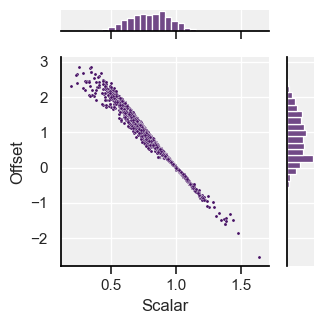

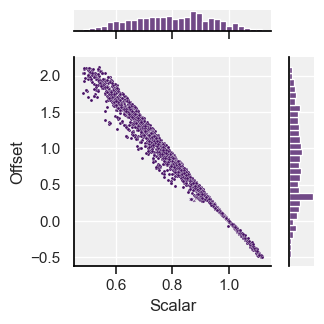

In [32]:
g = sns.jointplot(x="scalar",y="offset",data=all_factors,
    s=5,marginal_kws=dict(bins=30),
    color='#471164FF'
)
g.fig.set_figwidth(3.4)
g.fig.set_figheight(3.4)
plt.ylabel('Offset')
plt.xlabel('Scalar')
plt.tight_layout()
plt.savefig(run+"/plots/offset_vs_scalar.png", bbox_inches='tight')

q = sns.jointplot(x="scalar",y="offset",data=filtered_factors,
    s=5,marginal_kws=dict(bins=30),
    color='#471164FF'
)
q.fig.set_figwidth(3.4)
q.fig.set_figheight(3.4)
plt.ylabel('Offset')
plt.xlabel('Scalar')
plt.tight_layout()
# plt.savefig(run+"/plots/offset_vs_scalar.png", bbox_inches='tight')

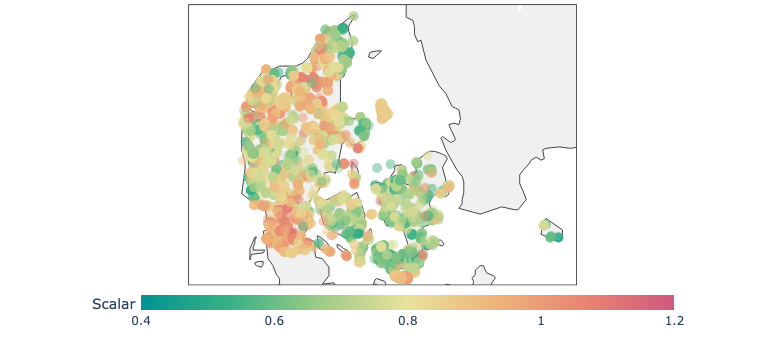

In [36]:
fig = px.scatter_geo(
    filtered_factors,lat='lat',lon='lon', 
    color = 'scalar',color_continuous_scale='Temps',
    color_continuous_midpoint=1,
    range_color=(0.4,1.2)
) 
fig.update_geos(
    resolution=50, 
    center=dict(lon=11.2, lat=56.2),
    lataxis_range=[54.6, 58], 
    lonaxis_range=[7,15.5],
    projection_type='mercator',
    landcolor=bg_colour
)
fig.update_traces(marker=dict(size=10, opacity=0.5))
fig.update_layout(
    margin=dict(l=5, r=5, t=5, b=5),
    width = 465, height = 340,
    coloraxis_colorbar=dict(
        len=0.8,
        yanchor = 'top',
        y=0,
        thickness=15,
        orientation='h'
))
fig.layout.coloraxis.colorbar.title = 'Scalar'
fig.show()

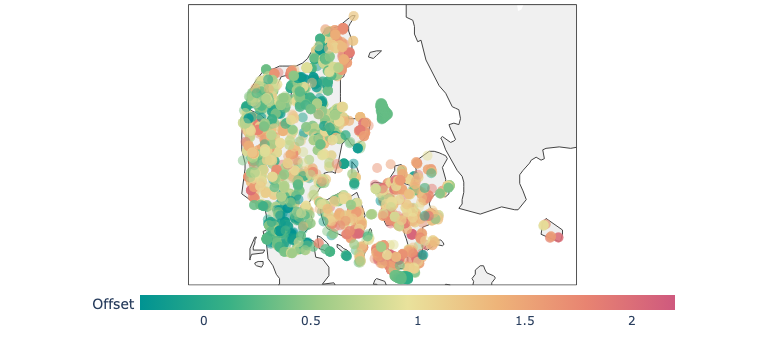

In [38]:
fig = px.scatter_geo(filtered_factors,lat='lat',lon='lon', 
    color = 'offset', color_continuous_scale='Temps',
    color_continuous_midpoint=0,
    range_color=(-0.3,2.2)
) 
fig.update_geos(
    resolution=50, 
    center=dict(lon=11.2, lat=56.2),
    lataxis_range=[54.6, 58], 
    lonaxis_range=[7,15.5],
    projection_type='mercator',
    landcolor=bg_colour
)
fig.update_traces(marker=dict(size=10, opacity=0.5))
fig.update_layout(
    margin=dict(l=5, r=5, t=5, b=5),
    width = 465, 
    height = 340,
    coloraxis_colorbar=dict(
        len=0.8,
        yanchor = 'top',
        y=0,
        thickness=15,
        orientation='h'
    )
)

fig.layout.coloraxis.colorbar.title = 'Offset'
fig.show()

### Extra Old Functions

In [ ]:
# PLOTTING THE MONTHLY VARIATION IN BIAS FACTORS

# month_factors = all_factors.groupby(['cluster', 'month'], as_index=False)[['lat','lon','scalar','offset']].mean()


# # plotting
# fig = px.scatter_geo(
#     month_factors,
#     lat='lat',
#     lon='lon', 
#     color = 'scalar',
#     hover_data=['scalar'],
#     facet_col='month',
#     facet_col_wrap=3,
#     color_continuous_scale='viridis', 
# ) 

# fig.update_geos(
#     resolution=50, 
#     center=dict(lon=11.2, lat=56),
#     lataxis_range=[54.8, 58.5], 
#     lonaxis_range=[7,15.5],
#     projection_type='mercator',
# )
# fig.update_traces(marker=dict(size=3.5, opacity=1))
# fig.update_layout(width = 800, height = 800)

# fig.show()


In [ ]:
#### monthly old
# def calc_monthly_error(df_sim, df_obs, turb_info):
#     df_obs['time'] = pd.to_datetime(df_obs['time'])
#     df_obs['month'] = df_obs.time.dt.month
#     df_obs_monthly = df_obs.drop(columns=['time']).set_index('month').reset_index()
#     df_obs_monthly = df_obs_monthly.melt(id_vars=['month'], var_name='ID', value_name='cf')
    
#     df_sim['time'] = pd.to_datetime(df_sim['time'])
#     df_sim['month'] = df_sim.time.dt.month
#     df_sim_monthly = df_sim.drop(columns=['time']).groupby('month').mean().reset_index()
#     df_sim_monthly = df_sim_monthly.melt(id_vars=['month'], var_name='ID', value_name='cf')

#     turb_info['ID'] = turb_info['ID'].apply(str)
    
#     merged = pd.merge(df_sim_monthly, df_obs_monthly, on=['ID', 'month'], suffixes=('_sim', '_obs'))
#     merged = pd.merge(merged, turb_info[['ID', 'capacity']], on='ID')
    
#     merged['diff'] = merged['cf_obs'] - merged['cf_sim']
#     merged['abdiff'] = np.abs(merged['diff'])
#     merged['sqdiff'] = merged['diff']**2
    
#     merged = merged.dropna(subset=['cf_sim', 'cf_obs', 'capacity'])

#     def weighted_avg(df, values, weights):
#         return (df[values] * df[weights]).sum() / df[weights].sum()

#     wavg = lambda x: weighted_avg(merged.loc[x.index], 'sqdiff', 'capacity')
#     wavg2 = lambda x: weighted_avg(merged.loc[x.index], 'abdiff', 'capacity')
#     wavg3 = lambda x: weighted_avg(merged.loc[x.index], 'cf_obs', 'capacity')

#     error = merged.groupby('month').agg({"sqdiff": wavg, 'abdiff': wavg2, 'cf_obs': wavg3})
#     # return error
#     rmse = (np.sqrt(error['sqdiff'])/error['cf_obs']).rename('rmse')
#     mae = (error['abdiff']/error['cf_obs']).rename('mae')

#     return rmse, mae


# USING THE YEARLY ERROR LIKE SIMON SUGGESTED
# def calc_yearly_error(df_sim, df_obs, turb_info, train=False):
#     if train == True:
#         df_obs = df_obs.pivot(
#                 index=['year','month'], 
#                 columns='ID', 
#                 values='obs').reset_index(drop=True)
#         df_obs['time'] = np.arange(str(2015)+'-01', str(2019+1)+'-01', dtype='datetime64[M]')
#         df_obs['month'] = df_obs.time.dt.month
#         df_obs_monthly = df_obs.drop(columns=['time']).groupby('month').mean()
        
#     else:
#         df_obs['time'] = pd.to_datetime(df_obs['time'])
#         df_obs['month'] = df_obs.time.dt.month
#         df_obs_monthly = df_obs.drop(columns=['time']).set_index('month')
    
#     df_sim['time'] = pd.to_datetime(df_sim['time'])
#     df_sim['month'] = df_sim.time.dt.month
#     df_sim_monthly = df_sim.drop(columns=['time']).groupby('month').mean()
    
#     df_sim_yearly = df_sim_monthly.mean().reset_index(name='CF')
#     df_sim_yearly.columns = 'ID', 'CF'
#     df_sim_yearly['ID'] = df_sim_yearly['ID'].apply(str)
    
#     df_obs_yearly = df_obs_monthly.mean().reset_index(name='CF')
#     df_obs_yearly.columns = 'ID', 'CF'
#     df_obs_yearly['ID'] = df_obs_yearly['ID'].apply(str)
    
#     turb_info['ID'] = turb_info['ID'].apply(str)
    
#     merged = pd.merge(df_sim_yearly, df_obs_yearly, on='ID', suffixes=('_sim', '_obs'))
#     merged = pd.merge(merged, turb_info[['ID', 'capacity']], on='ID')
    
#     merged['diff'] = merged['CF_sim'] - merged['CF_obs']
    
#     merged = merged.dropna(subset=['CF_sim', 'CF_obs', 'capacity'])

#     rmse = np.sqrt(np.average(np.square(merged['diff']), weights=merged['capacity']))
#     mae = np.average(np.abs(merged['diff']), weights=merged['capacity'])
#     return rmse, mae

# def calc_regional_error(df_sim, df_obs, turb_info, train=False):
#     if train == True:
#         df_obs = obs_cf_train.pivot(
#                 index=['year','month'], 
#                 columns='ID', 
#                 values='obs').reset_index(drop=True)
#         df_obs['time'] = np.arange(str(2015)+'-01', str(2019+1)+'-01', dtype='datetime64[M]')
#         df_obs['month'] = df_obs.time.dt.month
#         df_obs_monthly = df_obs.drop(columns=['time']).groupby('month').mean()
        
#     else:
#         df_obs['time'] = pd.to_datetime(df_obs['time'])
#         df_obs['month'] = df_obs.time.dt.month
#         df_obs_monthly = df_obs.drop(columns=['time']).set_index('month')
    
#     df_sim['time'] = pd.to_datetime(df_sim['time'])
#     df_sim['month'] = df_sim.time.dt.month
#     df_sim_monthly = df_sim.drop(columns=['time']).groupby('month').mean()
    
#     df_sim_yearly = df_sim_monthly.mean().reset_index(name='cf')
#     df_sim_yearly.columns = 'ID', 'cf'
#     df_sim_yearly['ID'] = df_sim_yearly['ID'].apply(str)
    
#     df_obs_yearly = df_obs_monthly.mean().reset_index(name='cf')
#     df_obs_yearly.columns = 'ID', 'cf'
#     df_obs_yearly['ID'] = df_obs_yearly['ID'].apply(str)
    
#     turb_info['ID'] = turb_info['ID'].apply(str)
    
#     merged = pd.merge(df_sim_yearly, df_obs_yearly, on='ID', suffixes=('_sim', '_obs'))
#     merged = pd.merge(merged, turb_info[['ID', 'capacity','region']], on='ID')

#     merged['diff'] = merged['cf_obs'] - merged['cf_sim']
#     merged['abdiff'] = np.abs(merged['diff'])
#     merged['sqdiff'] = merged['diff']**2
    
#     merged = merged.dropna(subset=['cf_sim', 'cf_obs', 'capacity'])

#     def weighted_avg(df, values, weights):
#         return (df[values] * df[weights]).sum() / df[weights].sum()

#     wavg = lambda x: weighted_avg(merged.loc[x.index], 'sqdiff', 'capacity')
#     wavg2 = lambda x: weighted_avg(merged.loc[x.index], 'abdiff', 'capacity')
#     wavg3 = lambda x: weighted_avg(merged.loc[x.index], 'cf_obs', 'capacity')

#     error = merged.groupby('region').agg({"sqdiff": wavg, 'abdiff': wavg2, 'cf_obs': wavg3})
#     # return error
#     rmse = (np.sqrt(error['sqdiff'])/error['cf_obs']).rename('rmse')
#     mae = (error['abdiff']/error['cf_obs']).rename('mae')
#     return rmse, mae


# def calc_regional_error2(df_sim, df_obs, turb_info):
#     df_obs['time'] = pd.to_datetime(df_obs['time'])
#     df_obs['month'] = df_obs.time.dt.month
#     df_obs_monthly = df_obs.drop(columns=['time']).set_index('month').reset_index()
#     df_obs_monthly = df_obs_monthly.melt(id_vars=['month'], var_name='ID', value_name='cf')
    
#     df_sim['time'] = pd.to_datetime(df_sim['time'])
#     df_sim['month'] = df_sim.time.dt.month
#     df_sim_monthly = df_sim.drop(columns=['time']).groupby('month').mean().reset_index()
#     df_sim_monthly = df_sim_monthly.melt(id_vars=['month'], var_name='ID', value_name='cf')

#     turb_info['ID'] = turb_info['ID'].apply(str)
    
#     merged = pd.merge(df_sim_monthly, df_obs_monthly, on=['ID', 'month'], suffixes=('_sim', '_obs'))
#     merged = pd.merge(merged, turb_info[['ID', 'capacity','region']], on='ID')
    
#     merged['diff'] = merged['cf_obs'] - merged['cf_sim']
#     merged['abdiff'] = np.abs(merged['diff'])
#     merged['sqdiff'] = merged['diff']**2
    
#     merged = merged.dropna(subset=['cf_sim', 'cf_obs', 'capacity'])

#     def weighted_avg(df, values, weights):
#         return (df[values] * df[weights]).sum() / df[weights].sum()

#     wavg = lambda x: weighted_avg(merged.loc[x.index], 'sqdiff', 'capacity')
#     wavg2 = lambda x: weighted_avg(merged.loc[x.index], 'abdiff', 'capacity')
#     wavg3 = lambda x: weighted_avg(merged.loc[x.index], 'cf_obs', 'capacity')

#     error = merged.groupby('region').agg({"sqdiff": wavg, 'abdiff': wavg2, 'cf_obs': wavg3})

#     rmse = (np.sqrt(error['sqdiff'])/error['cf_obs']).rename('rmse')
#     mae = (error['abdiff']/error['cf_obs']).rename('mae')

#     return rmse, mae


# def test_regional_error(run, year_test, country, turb_info, cluster_list, time_res_list=['yearly', 'season', 'bimonth', 'month']):
#     rmse_all = []
#     mae_all = []
#     cluster_all = []
#     time_all = []
#     regional_all = []

#     obs_cf = pd.read_csv(run+'/results/capacity-factor/'+country+"_"+str(year_test)+'_obs_cf.csv', parse_dates=['time'])
#     unc_cf = pd.read_csv(run+'/results/capacity-factor/'+country+"_"+str(year_test)+'_unc_cf.csv', parse_dates=['time'])
#     rmse, mae = calc_regional_error2(unc_cf, obs_cf, turb_info)

#     rmse_all.append(rmse)
#     mae_all.append(mae)
#     cluster_all.append([1]*len(rmse))
#     time_all.append(['uncorrected']*len(rmse))
#     regional_all.append(rmse.index)
    
#     for num_clu in cluster_list:
#         for time_res in time_res_list:
#             cor_cf = pd.read_csv(run+'/results/capacity-factor/'+country+"_"+str(year_test)+'_'+time_res+'_'+str(num_clu)+'_cor_cf.csv', parse_dates=['time'])
#             rmse, mae = calc_regional_error2(cor_cf, obs_cf, turb_info)
            
#             rmse_all.append(rmse)
#             mae_all.append(mae)
#             cluster_all.append([num_clu]*len(rmse))
#             time_all.append([time_res]*len(rmse))
#             regional_all.append(rmse.index)
    
    
#     df_metrics = pd.DataFrame(list(zip(np.ravel(regional_all), np.ravel(cluster_all), np.ravel(time_all), np.ravel(rmse_all), np.ravel(mae_all))), 
#                  columns =['region','num_clu', 'time_res', 'rmse', 'mae'])

#     return df_metrics


# def plot_regional_error(run, df_metrics, name):
#     fig, axes = plt.subplots(1, 2, figsize=(12, 3))
    
#     sns.lineplot(
#         x='region',y='rmse',
#         data = df_metrics[((df_metrics['time_res'] == 'season') | (df_metrics['time_res'] == 'yearly')) & ((df_metrics['num_clu'] == 1) | (df_metrics['num_clu'] == 500) | (df_metrics['num_clu'] == 3000))],
#         hue ="num_clu",style="time_res",palette="tab10",
#         ax = axes[0],
#         legend = False
#     )
#     axes[0].set_ylabel('RMSE')
#     axes[0].set_xlabel('Region')
    
#     sns.lineplot(
#         x='region',y='mae',
#         data = df_metrics[((df_metrics['time_res'] == 'season') | (df_metrics['time_res'] == 'yearly')) & ((df_metrics['num_clu'] == 1) | (df_metrics['num_clu'] == 500) | (df_metrics['num_clu'] == 3000))],
#         hue ="num_clu",style="time_res",palette="tab10",
#         ax = axes[1],
#         legend = True
#     )
    
#     axes[1].set_ylabel('MAE')
#     axes[1].set_xlabel('Region')
    
#     # fixing the legend labels and sharing it over whole plot.
#     axes[1].get_legend().remove()
#     handles, labels = plt.gca().get_legend_handles_labels()
#     print(labels)
#     labels = ['$n_{clu}$', '1', '500','3000', '$t_{freq}$', 'Fixed', 'Seasonal']
#     plt.legend(handles, labels, ncol=1, loc='right', bbox_to_anchor=(1.3, 0.5))
#     plt.tight_layout()
#     # plt.savefig(run+'/plots/'+country+'_'+name+'_error.png', bbox_inches='tight')
#     return plt.tight_layout()

In [ ]:
# def region_bounds(region_info):
#     region_coord = region_info.groupby('region')[['lat','lon']].mean().reset_index()
#     top = []
#     bot = []
#     left = []
#     right = []
#     lat = []
#     lon = []
#     for i in region_coord['region']:
#         top.append(region_info.where(region_info['region']==i)['lat'].max())
#         bot.append(region_info.where(region_info['region']==i)['lat'].min())
#         left.append(region_info.where(region_info['region']==i)['lon'].min())
#         right.append(region_info.where(region_info['region']==i)['lon'].max())

#         lat.append(region_info.where(region_info['region']==i)['lat'].max())
#         lat.append(region_info.where(region_info['region']==i)['lat'].max())
#         lat.append(region_info.where(region_info['region']==i)['lat'].min())
#         lat.append(region_info.where(region_info['region']==i)['lat'].min())
#         lat.append(region_info.where(region_info['region']==i)['lat'].max())
        
#         lon.append(region_info.where(region_info['region']==i)['lon'].max())
#         lon.append(region_info.where(region_info['region']==i)['lon'].min())
#         lon.append(region_info.where(region_info['region']==i)['lon'].min())
#         lon.append(region_info.where(region_info['region']==i)['lon'].max())
#         lon.append(region_info.where(region_info['region']==i)['lon'].max())

#         lat.append(None)
#         lon.append(None)
    
#     region_coord['top'] = top
#     region_coord['bot'] = bot
#     region_coord['left'] = left
#     region_coord['right'] = right
#     return region_coord, lat, lon
    
# attempt to add a border
# coords, lat, lon = region_bounds(region_info)
# fig.add_scattergeo(
#     lat = lat,
#     lon = lon,
#     mode = 'lines',
#     )
# fig.update_traces(marker=dict(size=5))

In [ ]:
## INTERPOLATING THE SCALAR AND OFFSET TO SHOW SPATIAL PATTERNS THIS WILL BE USEFUL FOR OTEHR STUF



from geocube.api.core import make_geocube
from geocube.rasterize import rasterize_points_griddata
from functools import partial

gdf = gpd.GeoDataFrame(
    all_factors, geometry=gpd.points_from_xy(all_factors['lon'], all_factors['lat']), crs="EPSG:4326",
)

denmark = gpd.read_file(run+"wind_data/DK/shape/DNK_adm0.shp")

geo_grid_cubic = make_geocube(
    gdf,
    measurements=["scalar", "offset"],
    resolution=(0.1, 0.1),
    rasterize_function=partial(rasterize_points_griddata, method="linear"),
    interpolate_na_method="nearest",
)


fig, ax = plt.subplots()

geo_grid_cubic.scalar.plot.imshow()

denmark.boundary.plot(
    ax=ax,
    alpha=0.7,
    color="black"
)

ax.set_axis_off()


fig, ax = plt.subplots()

geo_grid_cubic.offset.plot.imshow()

denmark.boundary.plot(
    ax=ax,
    alpha=0.7,
    color="black"
)

# ax.set_axis_off()

In [50]:
# # MINE FOR THE NEW ERRORS 14/02/2024
# def monthly_cf(df, value):
#     df = df.groupby(pd.Grouper(key='time',freq='M')).mean()
#     df = df.transpose().reset_index()
#     df.columns = ['ID','1','2','3','4','5','6','7','8','9','10','11','12']
#     return df.set_index('ID')

# def rmse_total(df, df_obs,turb_info):
#     df = monthly_cf(df, 'sim')
#     df_obs = monthly_cf(df_obs, 'obs')
#     diff = (df_obs.mean(axis=1) - df.mean(axis=1))**2
#     diff = diff.reset_index()
    
#     diff["ID"] = diff["ID"].astype(str)
#     turb_info["ID"] = turb_info["ID"].astype(str)
#     error = pd.merge(diff, turb_info[['ID','capacity']], on=['ID'], how='left')
#     error.columns = ['ID','error','capacity']

#     def weighted_avg(df, values, weights):
#             return (df[values] * df[weights]).sum() / df[weights].sum()
    
#     wavg = lambda x: weighted_avg(error.loc[x.index], 'error', 'capacity')
    
#     rmse = np.sqrt(error.agg({'error': wavg}))
#     return rmse.error

# def mae_total(df, df_obs,turb_info):
#     df = monthly_cf(df, 'sim')
#     df_obs = monthly_cf(df_obs, 'obs')
#     diff = np.abs(df_obs.mean(axis=1) - df.mean(axis=1))
#     diff = diff.reset_index()
    
#     diff["ID"] = diff["ID"].astype(str)
#     turb_info["ID"] = turb_info["ID"].astype(str)
#     error = pd.merge(diff, turb_info[['ID','capacity']], on=['ID'], how='left')
#     error.columns = ['ID','error','capacity']

#     def weighted_avg(df, values, weights):
#             return (df[values] * df[weights]).sum() / df[weights].sum()
    
#     wavg = lambda x: weighted_avg(error.loc[x.index], 'error', 'capacity')
    
#     rmse = error.agg({'error': wavg})
#     return rmse.error


# cf_obs = pd.read_csv(run+'/results/capacity-factor/'+country+"_"+str(year_test)+'_obs_cf.csv', parse_dates=['time'])
# cf_unc = pd.read_csv(run+'/results/capacity-factor/'+country+"_"+str(year_test)+'_unc_cf.csv', parse_dates=['time'])
# turb_info = pd.read_csv(run+'/training/simulated-turbines/'+country+"_"+str(year_test)+'_turb_info.csv')

# rmse_all = []
# mae_all = []
# cluster_all = []
# time_all = []

# rmse = rmse_monthly(cf_unc, cf_obs, turb_info)
# mae = mae_monthly(cf_unc, cf_obs, turb_info)

# rmse_all.append(rmse)
# mae_all.append(mae)
# cluster_all.append(1)
# time_all.append('uncorrected')

# for num_clu in cluster_list:
#     for time_res in time_res_list:
#         cf_cor = pd.read_csv(run+'/results/capacity-factor/'+country+"_"+str(year_test)+'_'+time_res+'_'+str(num_clu)+'_cor_cf.csv', parse_dates=['time'])
#         rmse = rmse_monthly(cf_cor, cf_obs, turb_info)
#         mae = mae_monthly(cf_cor, cf_obs, turb_info)
        
#         rmse_all.append(rmse)
#         mae_all.append(mae)
#         cluster_all.append(num_clu)
#         time_all.append(time_res)


# df_metrics = pd.DataFrame(list(zip(np.ravel(cluster_all), np.ravel(time_all), np.ravel(rmse_all), np.ravel(mae_all))), 
#              columns =['num_clu', 'time_res', 'rmse', 'mae'])


# ### ATTEMPT TO LOOK AT MONTHLY CF

# def monthly_cf(df, value):
#     df = df.groupby(pd.Grouper(key='time',freq='M')).mean()
#     df = df.transpose().reset_index()
#     df.columns = ['ID','1','2','3','4','5','6','7','8','9','10','11','12']
#     return df.set_index('ID')

# def rmse_monthly(df, df_obs,turb_info):
#     df = monthly_cf(df, 'sim')
#     df_obs = monthly_cf(df_obs, 'obs')
#     diff = (df_obs - df)**2
#     diff = diff.reset_index()
#     error = diff.melt(
#         id_vars=["ID"], # adding in turbine ID for merging
#         var_name="month", 
#         value_name='error'
#     )
    
#     error["ID"] = error["ID"].astype(str)
#     turb_info["ID"] = turb_info["ID"].astype(str)
#     error = pd.merge(error, turb_info[['ID','capacity']], on=['ID'], how='left')

#     def weighted_avg(df, values, weights):
#             return (df[values] * df[weights]).sum() / df[weights].sum()

#     wavg = lambda x: weighted_avg(error.loc[x.index], 'error', 'capacity')

#     error = error.groupby('month').agg({"error": wavg})
#     rmse = np.sqrt(error)
#     return rmse.reset_index()

# def mae_monthly(df, df_obs,turb_info):
#     df = monthly_cf(df, 'sim')
#     df_obs = monthly_cf(df_obs, 'obs')
#     diff = np.abs(df_obs - df)
#     diff = diff.reset_index()
#     error = diff.melt(
#         id_vars=["ID"], # adding in turbine ID for merging
#         var_name="month", 
#         value_name='error'
#     )
    
#     error["ID"] = error["ID"].astype(str)
#     turb_info["ID"] = turb_info["ID"].astype(str)
#     error = pd.merge(error, turb_info[['ID','capacity']], on=['ID'], how='left')

#     def weighted_avg(df, values, weights):
#             return (df[values] * df[weights]).sum() / df[weights].sum()

#     wavg = lambda x: weighted_avg(error.loc[x.index], 'error', 'capacity')

#     error = error.groupby('month').agg({"error": wavg})
#     mae = error
#     return mae.reset_index()

# cf_obs = pd.read_csv(run+'/results/capacity-factor/'+country+"_"+str(year_test)+'_obs_cf.csv', parse_dates=['time'])
# cf_unc = pd.read_csv(run+'/results/capacity-factor/'+country+"_"+str(year_test)+'_unc_cf.csv', parse_dates=['time'])
# turb_info = pd.read_csv(run+'/training/simulated-turbines/'+country+"_"+str(year_test)+'_turb_info.csv')

# rmse_all = []
# mae_all = []
# cluster_all = []
# time_all = []
# month_all = []


# rmse = rmse_monthly(cf_unc, cf_obs, turb_info)
# mae = mae_monthly(cf_unc, cf_obs, turb_info)

# rmse_all.append(rmse.error)
# mae_all.append(mae.error)
# cluster_all.append([1]*12)
# time_all.append(['uncorrected']*12)
# month_all.append(rmse.month)

# for num_clu in cluster_list:
#     for time_res in time_res_list:
#         cf_cor = pd.read_csv(run+'/results/capacity-factor/'+country+"_"+str(year_test)+'_'+time_res+'_'+str(num_clu)+'_cor_cf.csv', parse_dates=['time'])
#         rmse = rmse_monthly(cf_cor, cf_obs, turb_info)
#         mae = mae_monthly(cf_cor, cf_obs, turb_info)
        
#         rmse_all.append(rmse.error)
#         mae_all.append(mae.error)
#         cluster_all.append([num_clu]*12)
#         time_all.append([time_res]*12)
#         month_all.append(rmse.month)


# df_metrics = pd.DataFrame(list(zip(np.ravel(month_all), np.ravel(cluster_all), np.ravel(time_all), np.ravel(rmse_all), np.ravel(mae_all))), 
#              columns =['month','num_clu', 'time_res', 'rmse', 'mae'])


# month_metrics = df_metrics
# month_metrics['month'] = month_metrics['month'].astype(int)
# month_metrics= month_metrics.sort_values('month').reset_index(drop=True)
# # month_metrics['time_res'] = month_metrics['time_res'].astype(pd.StringDtype())
# month_metrics
# # month_metrics[(month_metrics['num_clu'] == choice2) & (month_metrics['time_res'] != 'uncorrected')]


# choice = 600 # the number of clusters you would like to analyse
# choice2 = 1 # secondary choice for comparison
# time_res = 'yearly' # choose between 'year', 'season', 'two_month', 'month'
# metric = 'rmse' # choose between 'MAE', 'ME', 'RMSE'

# fig, axes = plt.subplots(1, 2, figsize=(12, 3),sharey='all')

# sns.lineplot(
#     x="month",
#     y=metric,
#     data = month_metrics[(month_metrics['num_clu'] == choice2) & (month_metrics['time_res'] != 'uncorrected')],
#     hue ="time_res",
#     style= "time_res",
#     hue_order = ['month', 'bimonth', 'season', 'yearly'],
#     style_order= ['month', 'bimonth', 'season', 'yearly'],
#     ax = axes[0],
#     legend = False
# )



# sns.lineplot(
#     x="month",
#     y=metric,
#     data = month_metrics[(month_metrics['num_clu'] == choice)],
#     hue ="time_res",
#     style= "time_res",
#     hue_order = ['month', 'bimonth', 'season', 'yearly'],
#     style_order= ['month', 'bimonth', 'season', 'yearly'],
#     ax = axes[1],
#     legend = True
# )

# axes[0].set_ylabel(metric)
# axes[0].set_xlabel('Month')
# # axes[0].set_xticks(range(1,13))
# axes[0].set_title("No. of Clusters: "+str(choice2))

# axes[1].set_ylabel(metric)
# axes[1].set_xlabel('Month')
# # axes[1].set_xticks(range(1,13))
# axes[1].set_title("No. of Clusters: "+str(choice))


# # fixing the legend labels and sharing it over whole plot.
# # axes[1].get_legend().remove()
# # handles, labels = plt.gca().get_legend_handles_labels()
# # labels = ['Monthly', 'Bimonthly',  'Seasonal', 'Yearly'] # renaming labels
# # plt.legend(handles, labels, ncol=1, loc='right',bbox_to_anchor=(1.3, 0.5), title='Time Resolution')
# # plt.savefig(run+"plots/"+country+"_temporal_error.png", bbox_inches='tight')
# plt.tight_layout()